# Machine Learning Course 2025 HW2
The code scripts are from [aideml](https://github.com/WecoAI/aideml) project on github with some modifications.

AIDE: AI-Driven Exploration in the Space of Code

https://arxiv.org/pdf/2502.13138


<font color='red' size=6>Make a copy before running or editing the code.</font>

## Prerequisites

In [69]:
# check GPU
!nvidia-smi

Thu Aug 21 17:12:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.01              Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              5W /   95W |    1943MiB /   8188MiB |     46%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

>取消注释下面代码下载依赖

In [70]:
# install packages
# !pip install dataclasses_json==0.6.4 shutup==0.2.0

In [71]:
# # Download dataset

# !gdown --id 1Ah5uV6cu3Bnz6WfkUuxEZCLqj5k1lbpd

# # Choose a workable link
# # !gdown --id 1XtF9-hGw2tKe4WvUMW5YE6lj6p1QcWIc
# # !gdown --id 1diswE_9XoT-uII23ucRppau1ErEQkY2y
# # !gdown --id 1BAVMzLZqEgtG8rwog7ttC7xKPw5QTngn
# # !gdown --id 1PAI4_3kRWwIPQMscMdGt9HLqZZy1vWSD

# !unzip /content/ML2025Spring-hw2-public.zip

In [72]:
import os
try:
    os.remove('./best_solution.py')
    os.remove('./good_solution_0.py')
    os.remove('./good_solution_1.py')
except Exception as e:
    print(f"删除文件时出错: {e}")

删除文件时出错: [Errno 2] No such file or directory: './best_solution.py'


In [73]:
# openai模型api
import os
import openai
api_key=os.getenv('OPENAI_API_KEY') or 'your_api_key'
base_url=os.getenv('OPENAI_BASE_URL') or "your_base_url"
# model=os.getenv('OPENAI_MODEL') or "your_model"
model='qwen-coder-plus-latest'
# print(api_key,base_url,model)
client=openai.OpenAI(
    api_key=api_key,
    base_url=base_url,
)
def generate_response(prompt,system_prompt="",max_tokens=8192,temperature=0.3,stream=False):
    response=client.chat.completions.create(
        model=model,
        messages=[
            {
                'role': 'system',
                'content':system_prompt
            },
            {

                'role':'user',
                'content':prompt
            }
        ]
        ,max_tokens=max_tokens,
        temperature=temperature,
        stream=stream
    )
    if stream:
        # 处理流式输出
        def generate():
            for chunk in response:
                if chunk.choices[0].delta.content is not None:
                    yield chunk.choices[0].delta.content
        return generate()
    else:
        # 处理非流式输出
        return response.choices[0].message.content
print("模型api调用成功！")
# # 非流式调用
# result = generate_response("你是谁")
# print(result)

# # 流式调用
# for chunk in generate_response(prompt="喜欢什么", stream=True):
#     print(chunk, end="", flush=True)


模型api调用成功！


In [74]:
# from llama_cpp import Llama

# Load the model onto GPU
# myModel = Llama(
#     # ========================== TODO: try different LLM ==========================
#     # Before changing LLM, restart the session!
#     "./Meta-Llama-3.1-8B-Instruct-Q8_0.gguf",
#     verbose=False,
#     n_gpu_layers=-1,
#     n_ctx=8192,    # This argument is how many tokens the model can take. The longer the better, but it will consume more memory.
# )

# def generate_response(_model: Llama, _messages: str) -> str:
#     '''
#     This function will inference the model with given messages.
#     '''
#     _output = _model.create_chat_completion(
#         _messages,
#         stop=["<|eot_id|>", "<|end_of_text|>"],
#         max_tokens=4096,    # This argument is how many tokens the model can generate.
#         temperature=0.5,      # This argument is the randomness of the model. 0 means no randomness. We suggest setting the temperature value to 0 for reproducibility.
#     )["choices"][0]["message"]["content"]
#     return _output

## Functions

### Utils

In [75]:
# Define a function to save the best solution and other good solutions to files.
def save_run(cfg, journal):
    # Retrieve and save the best found solution.
    best_node = journal.get_best_node(only_good=False)  # Get the best node.
    with open("best_solution.py", "w") as f:
        f.write(best_node.code)

    good_nodes = journal.get_good_nodes()  # Retrieve all good solution nodes.
    for i, node in enumerate(good_nodes):
        filename = f"good_solution_{i}.py"
        with open(filename, "w") as f:
            f.write(node.code)

### Interpreter (DO NOT MODIFY THIS CELL)

In [76]:
"""
DO NOT MODIFY THIS CELL

Python interpreter for executing code snippets and capturing their output.
"""


import logging
import os
import queue
import signal
import sys
import time
import traceback
import zipfile
from pathlib import Path
from shutil import rmtree
import shutil
from multiprocessing import Process, Queue
from typing import Hashable, cast

import humanize
import rich
import shutup
from rich.logging import RichHandler
from rich.syntax import Syntax
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin


@dataclass
class ExecutionResult(DataClassJsonMixin):
    """
    Result of executing a code snippet in the interpreter.
    Contains the output, execution time, and exception information.
    """
    term_out: list[str]
    exec_time: float
    exc_type: str | None
    exc_info: dict | None = None
    exc_stack: list[tuple] | None = None

def exception_summary(e, exec_file_name):
    """Generates a string that summarizes an exception and its stack trace"""
    tb_lines = traceback.format_exception(e)
    # Combine the traceback lines into a single string, skipping lines that contain "importlib".
    tb_str = "".join(
        [
            line
            for line in tb_lines
            # if "importlib" not in line  # Filter out unwanted traceback lines.
        ]
    )

    exc_info = {}
    if hasattr(e, "args"):
        exc_info["args"] = [str(i) for i in e.args]  # Store the exception arguments as strings.
    for att in ["name", "msg", "obj"]:
        if hasattr(e, att):
            exc_info[att] = str(getattr(e, att))  # Store additional attributes if available.

    tb = traceback.extract_tb(e.__traceback__)  # Extract the traceback information.
    # Create a list of tuples for each frame in the traceback.
    exc_stack = [(t.filename, t.lineno, t.name, t.line) for t in tb]

    return tb_str, e.__class__.__name__, exc_info, exc_stack  # Return the formatted traceback and exception details.

# Define a class that redirects write operations to a multiprocessing queue.
class RedirectQueue:
    def __init__(self, queue, timeout=5):
        self.queue = queue  # Store the provided queue.
        self.timeout = timeout  # Set the timeout for queue operations.

    def write(self, msg):
        try:
            self.queue.put(msg, timeout=self.timeout)  # Attempt to put the message into the queue.
        except queue.Full:
            print.warning("Queue write timed out")  # Warn if the queue is full and the write times out.

    def flush(self):
        pass  # No operation is needed for flushing in this context.

# Define the Interpreter class that simulates a standalone Python REPL.
class Interpreter:
    def __init__(
        self,
        timeout: int = 3600,  # Default timeout of 3600 seconds.
        agent_file_name: str = "runfile.py",  # Default file name for writing the agent's code.
    ):
        """
        Simulates a standalone Python REPL with an execution time limit.

        Args:
            timeout (int, optional): Timeout for each code execution step. Defaults to 3600.
            agent_file_name (str, optional): The name for the agent's code file. Defaults to "runfile.py".
        """
        self.timeout = timeout  # Save the timeout value.
        self.agent_file_name = agent_file_name  # Save the agent file name.
        self.process: Process = None  # Initialize the process attribute (will hold the child process).

    def child_proc_setup(self, result_outq: Queue) -> None:
        # Import shutup to suppress warnings in the child process.
        import shutup

        shutup.mute_warnings()  # Mute all warnings before further execution.

        # Redirect both stdout and stderr to the provided result queue.
        # trunk-ignore(mypy/assignment)
        sys.stdout = sys.stderr = RedirectQueue(result_outq)

    def _run_session(
        self, code_inq: Queue, result_outq: Queue, event_outq: Queue
    ) -> None:
        self.child_proc_setup(result_outq)  # Set up the child process for capturing output.

        global_scope: dict = {}  # Create an empty dictionary to serve as the global scope.
        while True:  # Continuously wait for new code to execute.
            code = code_inq.get()  # Retrieve code from the code input queue.
            with open(self.agent_file_name, "w") as f:  # Open the agent file for writing.
                f.write(code)  # Write the received code into the file.

            event_outq.put(("state:ready",))  # Signal that the interpreter is ready to execute the code.
            try:
                # Compile and execute the code within the global scope.
                exec(compile(code, self.agent_file_name, "exec"), global_scope)
            except BaseException as e:
                # If an exception occurs, generate a summary of the exception.
                tb_str, e_cls_name, exc_info, exc_stack = exception_summary(
                    e,
                    self.agent_file_name,
                )
                result_outq.put(tb_str)  # Put the traceback string into the result queue.
                if e_cls_name == "KeyboardInterrupt":
                    e_cls_name = "TimeoutError"  # Convert a KeyboardInterrupt into a TimeoutError.

                event_outq.put(("state:finished", e_cls_name, exc_info, exc_stack))  # Signal that execution finished with an error.
            else:
                event_outq.put(("state:finished", None, None, None))  # Signal that execution finished successfully.

            os.remove(self.agent_file_name)  # Remove the agent file after execution.

            result_outq.put("<|EOF|>")  # Put an EOF marker to indicate the end of output.

    def create_process(self) -> None:
        # Create three queues for communication with the child process:
        # - code_inq: for sending code to execute.
        # - result_outq: for receiving output from the execution.
        # - event_outq: for receiving state events (like ready and finished).
        # trunk-ignore(mypy/var-annotated)
        self.code_inq, self.result_outq, self.event_outq = Queue(), Queue(), Queue()
        self.process = Process(
            target=self._run_session,  # Set the target function for the child process.
            args=(self.code_inq, self.result_outq, self.event_outq),  # Provide the necessary queues as arguments.
        )
        self.process.start()  # Start the child process.

    def cleanup_session(self):
        if self.process is None:  # If there is no process, nothing to clean up.
            return
        try:
            # Attempt to terminate the child process gracefully.
            self.process.terminate()  # Request the process to terminate.
            self.process.join(timeout=0.5)  # Wait for the process to finish with a 0.5-second timeout.

            if self.process.exitcode is None:  # If the process is still running,
                self.process.kill()  # Forcefully kill the process.
                self.process.join(timeout=0.5)  # Wait again for termination.

                if self.process.exitcode is None:  # If the process still hasn't terminated,
                    os.kill(self.process.pid, signal.SIGKILL)  # Send a SIGKILL signal.
        except Exception as e:
            print(f"Error during process cleanup: {e}")  # Print an error message if cleanup fails.
        finally:
            if self.process is not None:  # If the process exists,
                self.process.close()  # Close the process.
                self.process = None  # Reset the process attribute to None.

    def run(self, code: str, reset_session=True) -> ExecutionResult:
        """
        Execute the provided Python command in a separate process and return its output.

        Parameters:
            code (str): Python code to execute.
            reset_session (bool, optional): Whether to reset the interpreter session before executing the code. Defaults to True.

        Returns:
            ExecutionResult: Object containing the output and metadata of the code execution.
        """

        if reset_session:
            if self.process is not None:
                # If a previous process exists, clean it up before starting a new one.
                self.cleanup_session()
            self.create_process()  # Create a new child process.
        else:
            # For the first execution, reset_session must be True.
            assert self.process is not None

        assert self.process.is_alive()  # Ensure that the child process is running.

        self.code_inq.put(code)  # Send the code to the child process via the queue.

        # Wait for the child process to signal that it is ready.
        try:
            state = self.event_outq.get(timeout=10)  # Wait up to 10 seconds for the "state:ready" event.
        except queue.Empty:
            msg = "REPL child process failed to start execution"
            print.critical(msg)  # Log a critical error if the process does not start.
            while not self.result_outq.empty():
                continue  # Drain the result queue.
            raise RuntimeError(msg) from None
        assert state[0] == "state:ready", state  # Verify that the received state is "state:ready".
        start_time = time.time()  # Record the start time of execution.

        child_in_overtime = False  # Flag to indicate if the child process has exceeded the timeout.

        while True:
            try:
                # Try to get the finished state from the child process.
                state = self.event_outq.get(timeout=1)  # Wait for the "state:finished" event.
                assert state[0] == "state:finished", state  # Ensure the state is "state:finished".
                exec_time = time.time() - start_time  # Calculate the total execution time.
                break  # Exit the loop if execution is finished.
            except queue.Empty:
                # If no event is received, check whether the process is still alive.
                if not child_in_overtime and not self.process.is_alive():
                    msg = "REPL child process died unexpectedly"
                    raise RuntimeError(msg) from None

                # If the process is still running, check if it has exceeded the timeout.
                if self.timeout is None:
                    continue
                running_time = time.time() - start_time  # Determine the running time.
                if running_time > self.timeout:
                    print(f"Execution exceeded timeout of {self.timeout}s")  # Log a timeout message.
                    os.kill(self.process.pid, signal.SIGINT)  # Send SIGINT to the process.
                    child_in_overtime = True  # Mark that the process is now in overtime.

                    # If the process exceeds the timeout by more than 5 seconds, force cleanup.
                    if running_time > self.timeout + 5:
                        self.cleanup_session()  # Clean up the child process.

                        state = (None, "TimeoutError", {}, [])  # Set state to indicate a timeout error.
                        exec_time = self.timeout  # Set the execution time to the timeout limit.
                        break

        output: list[str] = []  # Initialize a list to collect output lines.
        # Collect all output from the result queue until the EOF marker is encountered.
        start_collect = time.time()  # Record the start time for output collection.
        while not self.result_outq.empty() or not output or output[-1] != "<|EOF|>":
            try:
                # If output collection exceeds 5 seconds, log a warning.
                if time.time() - start_collect > 5:
                    print.warning("Output collection timed out")
                    break
                output.append(self.result_outq.get(timeout=1))  # Append the next line of output.
            except queue.Empty:
                continue  # Continue if no output is available immediately.
        output.pop()  # Remove the EOF marker from the output list.

        # Extract exception information from the finished state.
        e_cls_name, exc_info, exc_stack = state[1:]

        if e_cls_name == "TimeoutError":
            # Append a timeout error message to the output if a timeout occurred.
            output.append(
                f"TimeoutError: Execution exceeded the time limit of {humanize.naturaldelta(self.timeout)}"
            )
        else:
            # Append the execution time information to the output.
            output.append(
                f"Execution time: {humanize.naturaldelta(exec_time)} seconds (time limit is {humanize.naturaldelta(self.timeout)})."
            )
        # Return an ExecutionResult object with all the execution details.
        return ExecutionResult(output, exec_time, e_cls_name, exc_info, exc_stack)



### Nodes


In [77]:
import time
import uuid
from dataclasses import dataclass, field
from typing import Literal, Optional

from dataclasses_json import DataClassJsonMixin


@dataclass(eq=False)
class Node(DataClassJsonMixin):
    """A single node in the solution tree. Contains code, execution results, and evaluation information."""

    # ---- code & plan ----
    code: str
    plan: str = field(default=None, kw_only=True)  # type: ignore

    # ---- general attrs ----
    step: int = field(default=None, kw_only=True)  # type: ignore
    id: str = field(default_factory=lambda: uuid.uuid4().hex, kw_only=True)
    ctime: float = field(default_factory=lambda: time.time(), kw_only=True)
    parent: Optional["Node"] = field(default=None, kw_only=True)
    children: set["Node"] = field(default_factory=set, kw_only=True)

    # ---- execution info ----
    _term_out: list[str] = field(default=None, kw_only=True)  # type: ignore
    exec_time: float = field(default=None, kw_only=True)  # type: ignore
    exc_type: str | None = field(default=None, kw_only=True)
    exc_info: dict | None = field(default=None, kw_only=True)
    exc_stack: list[tuple] | None = field(default=None, kw_only=True)

    # ---- evaluation ----
    # post-execution result analysis (findings/feedback)
    analysis: str = field(default=None, kw_only=True)  # type: ignore
    metric: float = field(default=None, kw_only=True)  # type: ignore
    # whether the agent decided that the code is buggy
    # -> always True if exc_type is not None or no valid metric
    is_buggy: bool = field(default=None, kw_only=True)  # type: ignore

    def __post_init__(self) -> None:
        if self.parent is not None:
            self.parent.children.add(self)

    @property
    def stage_name(self) -> Literal["draft", "debug", "improve"]:
        """
        Return the stage of the node:
        - "stage" if the node is an initial solution draft
        - "debug" if the node is the result of a debugging step
        - "improve" if the node is the result of an improvement step
        """
        if self.parent is None:
            return "draft"
        return "debug" if self.parent.is_buggy else "improve"

    def absorb_exec_result(self, exec_result: ExecutionResult):
        """Absorb the result of executing the code from this node."""
        self._term_out = exec_result.term_out
        self.exec_time = exec_result.exec_time
        self.exc_type = exec_result.exc_type
        self.exc_info = exec_result.exc_info
        self.exc_stack = exec_result.exc_stack

    @property
    def term_out(self) -> str:
        """Get the terminal output of the code execution (after truncating it)."""
        return trim_long_string("".join(self._term_out))

    @property
    def is_leaf(self) -> bool:
        """Check if the node is a leaf node in the solution tree."""
        return not self.children

    def __eq__(self, other):
        return isinstance(other, Node) and self.id == other.id

    def __hash__(self):
        return hash(self.id)

    @property
    def debug_depth(self) -> int:
        """
        Length of the current debug path
        - 0 if the node is not a debug node (parent is not buggy)
        - 1 if the parent is buggy but the skip parent isn't
        - n if there were n consecutive debugging steps
        """
        if self.stage_name != "debug":
            return 0
        return self.parent.debug_depth + 1  # type: ignore

### Tree

In [78]:
@dataclass
class Journal(DataClassJsonMixin):
    """A collection of nodes representing the solution tree."""

    nodes: list[Node] = field(default_factory=list)

    def __getitem__(self, idx: int) -> Node:
        return self.nodes[idx]

    def __len__(self) -> int:
        """Return the number of nodes in the journal."""
        return len(self.nodes)

    def append(self, node: Node) -> None:
        """Append a new node to the journal."""
        node.step = len(self.nodes)
        self.nodes.append(node)

    @property
    def draft_nodes(self) -> list[Node]:
        """Return a list of nodes representing intial coding drafts"""
        return [n for n in self.nodes if n.parent is None]

    @property
    def buggy_nodes(self) -> list[Node]:
        """Return a list of nodes that are considered buggy by the agent."""
        return [n for n in self.nodes if n.is_buggy]

    @property
    def good_nodes(self) -> list[Node]:
        """Return a list of nodes that are not considered buggy by the agent."""
        return [n for n in self.nodes if not n.is_buggy]

    def get_metric_history(self) -> list[float]:
        """Return a list of all metric values in the journal."""
        return [n.metric for n in self.nodes]

    def get_good_nodes(self) -> Node:
        return [n for n in self.nodes if not n.is_buggy]

    def get_best_node(self, only_good=True) -> None | Node:
        """Return the best solution found so far (node with the highest validation metric)."""
        if only_good:
            nodes = self.good_nodes
            if not nodes:
                return None
        else:
            nodes = self.nodes
        return min(nodes, key=lambda n: n.metric)

    def generate_summary(self, include_code: bool = False) -> str:
        """Generate a summary of the journal for the agent."""
        summary = []
        for n in self.good_nodes:
            summary_part = f"Design: {n.plan}\n"
            if include_code:
                summary_part += f"Code: {n.code}\n"
            summary_part += f"Results: {n.analysis}\n"
            summary_part += f"Validation Metric (Mean Squared Error): {n.metric}\n"
            summary.append(summary_part)
        return "\n-------------------------------\n".join(summary)

### Agent

In [79]:
import random
from typing import Any, Callable, cast

import re
import sys
import json
import humanize

from pydantic import BaseModel

ExecCallbackType = Callable[[str, bool], ExecutionResult]


class Agent:
    def __init__(
        self,
        cfg,
        journal: Journal,
    ):
        super().__init__()
        self.cfg = cfg
        self.journal = journal
        self.data_preview: str | None = None

    def search_policy(self) -> Node | None:
        """Select a node to work on (or None to draft a new node)."""
        search_cfg = self.cfg.agent.search

        # initial drafting
        if len(self.journal.draft_nodes) < search_cfg.num_drafts:
            return None

        # debugging
        if random.random() < search_cfg.debug_prob:
            # nodes that are buggy + leaf nodes + debug depth < max debug depth
            debuggable_nodes = [
                n
                for n in self.journal.buggy_nodes
                if n.is_leaf
            ]
            if debuggable_nodes:
                return random.choice(debuggable_nodes)


        # back to drafting if no nodes to improve
        good_nodes = self.journal.good_nodes
        if not good_nodes:
            return None

        # greedy
        greedy_node = self.journal.get_best_node()

        return greedy_node


    def plan_and_code_query(self, system_message, user_message, retries=3) -> tuple[str, str]:
        """Generate a natural language plan + code in the same LLM call and split them apart."""
        completion_text = None
        for _ in range(retries):

            response = generate_response(
                prompt=user_message,
                system_prompt=system_message,
            )
            completion_text = response
            code = extract_code(completion_text)
            nl_text = extract_text_up_to_code(completion_text)

            if code:
                return nl_text, code

            print("Plan + code extraction failed, retrying...")
        print("Final plan + code extraction attempt failed, giving up...")
        return "", completion_text

    def _draft(self) -> Node:

        # ================ TODO: ask LLM agents to come up with a solution and then implement ================

        # system_prompt = "You are an AI agent."

        # user_prompt = [
        #     "You have to come up with a solution for machine learning task and then implement this solution in Python."
        #     f"The task is to {str(self.cfg.task_goal)} ",
        #     f'All the provided input data is stored in "{self.cfg.data_dir}" directory.',
        #     f"{str(self.data_preview)}",
        #     'You have to save the predictions result on testing set in "/content/submission.csv".',
        #     'Note that the testing file DOES NOT have the target column.'
        # ]
        system_prompt = """You are an expert AI agent specializing in time series prediction and data analysis. 
You are running on Ubuntu 22.04.5 LTS with Python 3.11.
Your task is to develop a solution that predicts testing probabilities based on survey data.
You should:
1. Analyze the data structure and features
2. Design an appropriate model architecture
3. Implement the solution in Python
4. Ensure the code is well-documented and follows best practices
5. Save predictions to the specified output file

Focus on creating a robust solution that minimizes Mean Squared Error (MSE)."""

        user_prompt = [
            "Task: Develop a machine learning model to predict testing probabilities.",
            f"Goal: {str(self.cfg.task_goal)}",
            f"Data Location: {self.cfg.data_dir}",
            f"Data Overview:\n{str(self.data_preview)}",
            "Requirements:",
            "1. Save predictions to '/content/submission.csv'",
            "2. Note that the testing file DOES NOT have the target column",
            "3. Implement proper data preprocessing",
            "4. Use appropriate model selection and validation",
            "\nNeed to provide:",
            "1. A detailed plan explaining your approach",
            "2. Full Python implementation",
            "\nNote:",
            "1. Token limit is 8192.",
        ]
        system_message = system_prompt
        user_message = "\n".join(user_prompt)
        print(f'user_message: {user_message}')

        plan, code = self.plan_and_code_query(system_message=system_message, user_message=user_message)
        return Node(plan=plan, code=code)

    def _improve(self, parent_node: Node) -> Node:

        # ================  TODO: ask LLM agent to improve drafts ================

        # system_prompt = "You are an AI assistant."

        # user_prompt = [
        #     f"Task description: {str(self.cfg.task_goal)} "
        #     f"Memory: {str(self.journal.generate_summary())} "
        #     f"Previous solution: Code: {str(wrap_code(parent_node.code))} "
        # ]
        system_prompt = """You are an expert AI agent tasked with improving an existing prediction model.
You are running on Ubuntu 22.04.5 LTS with Python 3.11.
Your goal is to enhance the model's performance by:
1. Analyzing the current implementation
2. Identifying potential improvements
3. Implementing optimizations
4. Maintaining or improving code quality

Focus on reducing the Mean Squared Error (MSE) while keeping the solution practical and efficient."""

        user_prompt = [
            "Task: Improve the existing prediction model",
            f"Original Goal: {str(self.cfg.task_goal)}",
            "Previous Solutions:",
            f"{str(self.journal.generate_summary())}",
            "Current Implementation:",
            f"Code:\n{str(wrap_code(parent_node.code))}",
            "\nNeed to provide:",
            "1. Analysis of current implementation",
            "2. Specific improvement plan",
            "3. Enhanced implementation"
        ]
        system_message = system_prompt
        user_message = "\n".join(user_prompt)
        
        print(f'user_message: {user_message}')

        plan, code = self.plan_and_code_query(system_message=system_message, user_message=user_message)
        return Node(plan=plan, code=code, parent=parent_node)

    def _debug(self, parent_node: Node) -> Node:

        # ================  TODO: ask LLM agent to debug ================
        # system_prompt = "You are an AI agent."


        # user_prompt = [
        #     f"Task description: {str(self.cfg.task_goal)}\n\n",
        #     f"Previous (buggy) implementation: {str(wrap_code(parent_node.code))}\n\n",
        #     f"Execution output: {str(wrap_code(parent_node.term_out, lang=''))}\n\n",
        #     str(self.data_preview)
        # ]
        system_prompt = """You are an expert AI agent debugger specializing in machine learning code.
You are running on Ubuntu 22.04.5 LTS with Python 3.11.
Your task is to:
1. Analyze the error or issue in the current implementation
2. Identify the root cause
3. Propose and implement a fix
4. Ensure the solution maintains good performance

Focus on creating a robust fix that resolves the issue while maintaining or improving the model's performance."""

        user_prompt = [
            "Task: Debug and fix the prediction model",
            f"Original Goal: {str(self.cfg.task_goal)}",
            "Current Implementation:",
            f"Code:\n{str(wrap_code(parent_node.code))}",
            "Execution Output:",
            f"{str(wrap_code(parent_node.term_out, lang=''))}",
            "Data Context:",
            f"{str(self.data_preview)}",
            "\nNeed to provide:",
            "1. Analysis of the error/issue",
            "2. Root cause identification",
            "3. Proposed fix",
            "4. Corrected implementation"
        ]

        system_message = system_prompt
        user_message = "\n".join(user_prompt)
        print(f'user_message: {user_message}')

        plan, code = self.plan_and_code_query(system_message=system_message, user_message=user_message)
        return Node(plan=plan, code=code, parent=parent_node)

    def update_data_preview(
        self,
    ):
        self.data_preview = data_preview_generate(cfg.data_dir)

    def step(self, exec_callback: ExecCallbackType):
        if not self.journal.nodes or self.data_preview is None:
            self.update_data_preview()

        parent_node = self.search_policy()
        if parent_node is None:
            result_node = self._draft()
        elif parent_node.is_buggy:
            result_node = self._debug(parent_node)
        else:
            result_node = self._improve(parent_node)

        self.parse_exec_result(
            node=result_node,
            exec_result=exec_callback(result_node.code, True),
        )
        self.journal.append(result_node)

    def parse_exec_result(self, node: Node, exec_result: ExecutionResult):
        node.absorb_exec_result(exec_result)

        system_prompt = "You are an AI assistant. You are running on Ubuntu 22.04.5 LTS with Python 3.11."


        # ================  TODO: ask LLM agent to extract evaluation result from the execution output. ================
        # save log file
        # user_prompt = f"""
        #     The task is:
        #     {self.cfg.task_goal}

        #     The code implementation is:
        #     {wrap_code(node.code)}

        #     The execution output is:
        #     {wrap_code(node.term_out, lang="")}
        # """
        user_prompt = f"""
Task: Evaluate the prediction model implementation

Original Goal:
{self.cfg.task_goal}

Implementation:
{wrap_code(node.code)}

Execution Output:
{wrap_code(node.term_out, lang="")}

Need to provide a structured analysis including:
1. Execution Status (Success/Error)
2. Performance Metrics (especially MSE)
3. Issues or Concerns (if any)
4. Overall Assessment"""

        system_message = system_prompt
        # user_message = " ".join(user_prompt)
        user_message = user_prompt

        print(f'user_message: {user_message}')
        response = generate_response(
                prompt=user_message,
                system_prompt=system_message,
            )

        # ================  TODO: evaluation ================
        # you can force the LLM to structure the output to extract the metric
        # reference: https://python.useinstructor.com/integrations/llama-cpp-python/#llama-cpp-python
        # node.analysis = response.summary
        # node.is_buggy = (
        #     response.is_buggy
        #     or node.exc_type is not None
        #     or response.metric is None
        # )

        try:
            parsed_response = json.loads(response)
            node.analysis = parsed_response.get("assessment", "")
            node.metric = parsed_response["mse"] if parsed_response.get("mse") is not None else 0.0
            node.is_buggy = (
                parsed_response.get("execution_status", "Error") == "Error"
                or node.exc_type is not None
                or node.metric is None
            )
        except Exception as e:
            print("Failed to parse evaluation response:", e)
            node.analysis = "Failed to parse evaluation response."
            node.is_buggy = False
            node.metric = 0.0

### Text Processing

In [80]:
import json
import re

def wrap_code(code: str, lang="python") -> str:
    """Wraps code with three backticks."""
    return f"```{lang}\n{code}\n```"


def is_valid_python_script(script):
    """Check if a script is a valid Python script."""
    try:
        compile(script, "<string>", "exec")
        return True
    except SyntaxError:
        return False


def extract_jsons(text):
    """Extract all JSON objects from the text. Caveat: This function cannot handle nested JSON objects."""
    json_objects = []

    # Find {} by regular expression
    matches = re.findall(r"\{.*?\}", text, re.DOTALL)

    # Try to transform string into json objects
    for match in matches:
        try:
            json_obj = json.loads(match)
            json_objects.append(json_obj)
        except json.JSONDecodeError:
            pass

    return json_objects

def trim_long_string(string, threshold=5100, k=2500):
    # Check if the length of the string is longer than the threshold
    if len(string) > threshold:
        # Output the first k and last k characters
        first_k_chars = string[:k]
        last_k_chars = string[-k:]

        truncated_len = len(string) - 2 * k

        return f"{first_k_chars}\n ... [{truncated_len} characters truncated] ... \n{last_k_chars}"
    else:
        return string

def extract_code(text):
    """Extract python code blocks from the text."""
    parsed_codes = []

    # When code is in a text or python block
    matches = re.findall(r"```(python)?\n*(.*?)\n*```", text, re.DOTALL)
    for match in matches:
        code_block = match[1]
        parsed_codes.append(code_block)

    # When the entire text is code or backticks of the code block is missing
    if len(parsed_codes) == 0:
        matches = re.findall(r"^(```(python)?)?\n?(.*?)\n?(```)?$", text, re.DOTALL)
        if matches:
            code_block = matches[0][2]
            parsed_codes.append(code_block)

    # validate the parsed codes
    valid_code_blocks = [
        c for c in parsed_codes if is_valid_python_script(c)
    ]
    return "\n\n".join(valid_code_blocks)

def extract_text_up_to_code(s):
    """Extract (presumed) natural language text up to the start of the first code block."""
    if "```" not in s:
        return ""
    return s[: s.find("```")].strip()



### Feature Selection

In [81]:
import json
from pathlib import Path

import humanize
import pandas as pd


def preview_csv(p: Path) -> str:
    """Generate a textual preview of a csv file"""

    df = pd.read_csv(p)

    out = []

    out.append(f"-> {str(p)} has {df.shape[0]} rows and {df.shape[1]} columns.")

    # ================  TODO: Tell LLM agents which feature is useful for prediction ================

    cols = df.columns.tolist()
    cols_str = ", ".join(cols)
    res = f"The columns are: {cols_str}"

    out.append(res)

    return "\n".join(out)

def data_preview_generate(base_path):
    """
    Generate a textual preview of a directory
    """

    result = []
    files = [p for p in Path(base_path).iterdir()]
    for f in sorted(files):
        result.append(preview_csv(f))

    result = "\n\n".join(result)

    return result


## Config

In [82]:
import torch
import random
import numpy as np

# DO NOT MODIFY THIS CELL
class Config:
    """
    A recursive configuration class that converts a dictionary into an object
    with attributes accessible using dot notation.
    """

    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                value = Config(value)
            setattr(self, key, value)

def set_seed(seed=531):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed()

In [83]:
# ================  TODO: config ================
config = {
    # experiment configurations
    "exp_name": "ML2025_HW2",
    "data_dir":  Path("./ML2025Spring-hw2-public").resolve(),

    # the description of the task
    "task_goal": "Given the survey results from the past two days in a specific state in the U.S.,\
                  predict the probability of testing positive on day 3. \
                  The evaluation metric is Mean Squared Error (MSE).",

    "agent": {
        # the number of iterations
        "steps": 5,
        "search": {
            # decide whether to debug or improve
            "debug_prob": 0.5,
            # the number of draft generated before improving/debugging
            "num_drafts": 5,
        },
    },
}

cfg = Config(config)

## Main

In [84]:
def main():

    def exec_callback(*args, **kwargs):
        res = interpreter.run(*args, **kwargs)
        return res

    journal = Journal()
    agent = Agent(
        cfg=cfg,
        journal=journal,
    )

    interpreter = Interpreter()

    global_step = len(journal)
    while global_step < cfg.agent.steps:
        # run agent
        agent.step(exec_callback=exec_callback)
        # save results for this iteration
        save_run(cfg, journal)
        # get currect step
        global_step = len(journal)


    # Kill created child process
    interpreter.cleanup_session()


if __name__ == "__main__":
    main()
    print("Done!")


user_message: Task: Develop a machine learning model to predict testing probabilities.
Goal: Given the survey results from the past two days in a specific state in the U.S.,                  predict the probability of testing positive on day 3.                   The evaluation metric is Mean Squared Error (MSE).
Data Location: /home/hllqk/projects/ML2025spring-hw/ML2025Spring-hw2/ML2025Spring-hw2-public
Data Overview:
-> /home/hllqk/projects/ML2025spring-hw/ML2025Spring-hw2/ML2025Spring-hw2-public/sample_submission.csv has 997 rows and 2 columns.
The columns are: id, tested_positive_day3

-> /home/hllqk/projects/ML2025spring-hw/ML2025Spring-hw2/ML2025Spring-hw2-public/test.csv has 997 rows and 88 columns.
The columns are: id, AL, AZ, CA, CO, CT, FL, GA, IL, IN, IA, KS, KY, LA, ME, MD, MA, MI, MN, MO, NJ, NM, NY, NC, OH, OK, OR, PA, SC, TN, TX, VA, WA, WV, WI, cli_day1, ili_day1, wnohh_cmnty_cli_day1, wbelief_masking_effective_day1, wbelief_distancing_effective_day1, wcovid_vaccinated_f

/home/hllqk/miniconda3/envs/deeplearn/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:299: UserWarning: resource_tracker: There appear to be 22 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/hllqk/miniconda3/envs/deeplearn/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:299: UserWarning: resource_tracker: There appear to be 1 leaked folder objects to clean up at shutdown
  warnings.warn(


user_message: 
Task: Evaluate the prediction model implementation

Original Goal:
Given the survey results from the past two days in a specific state in the U.S.,                  predict the probability of testing positive on day 3.                   The evaluation metric is Mean Squared Error (MSE).

Implementation:
```python
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import os

# Set the directory path
data_dir = '/home/hllqk/projects/ML2025spring-hw/ML2025Spring-hw2/ML2025Spring-hw2-public'

# Load datasets
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir,

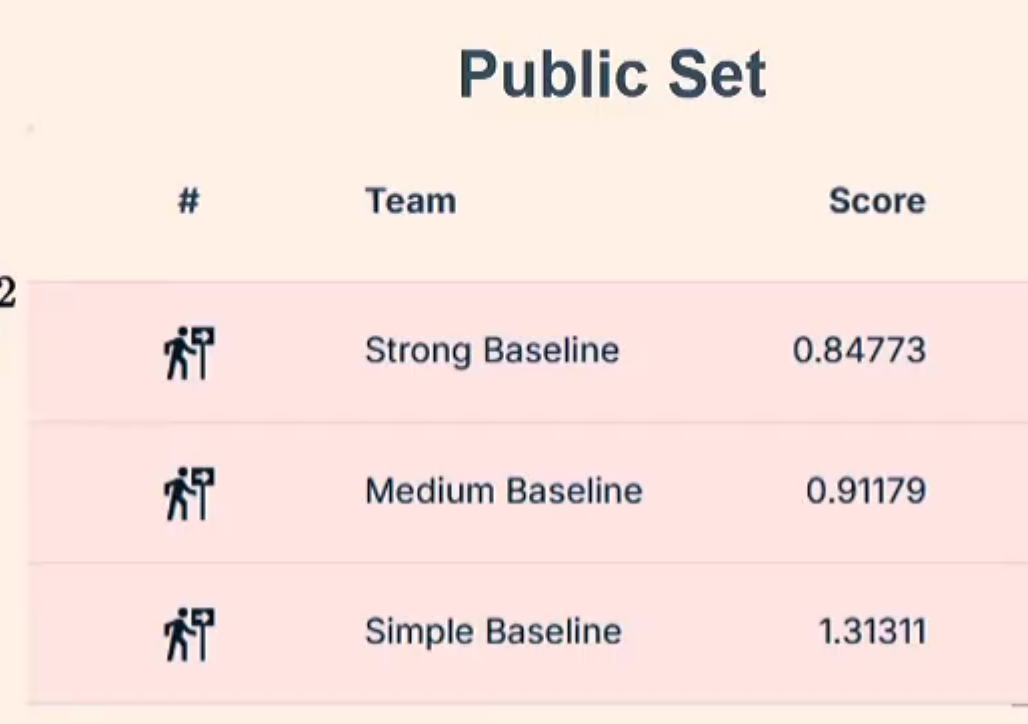

In [ ]:
# Get your best result!
!python best_solution.py

   id  AL  AZ  ...  public_transit_day3  worried_finances_day3  tested_positive_day3
0   0   1   0  ...             2.704414              39.222329             18.490787
1   1   1   0  ...             2.474973              41.209073             16.329253
2   2   1   0  ...             2.569940              39.636816             16.522931
3   3   1   0  ...             2.610086              38.926817             15.578501
4   4   1   0  ...             2.790749              39.840306             14.171920

[5 rows x 89 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009 entries, 0 to 3008
Data columns (total 89 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3009 non-null   int64  
 1   AL                                 3009 non-null   int64  
 2   AZ                                 3009 non-null   int64  
 3   CA                                 

/home/hllqk/miniconda3/envs/deeplearn/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:299: UserWarning: resource_tracker: There appear to be 22 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/hllqk/miniconda3/envs/deeplearn/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:299: UserWarning: resource_tracker: There appear to be 1 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/hllqk/miniconda3/envs/deeplearn/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:299: UserWarning: resource_tracker: There appear to be 22 leaked semlock objects to clean up at shutdown
  warnings.warn(
/home/hllqk/miniconda3/envs/deeplearn/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:299: UserWarning: resource_tracker: There appear to be 1 leaked folder objects to clean up at shutdown
  warnings.warn(
/home/hllqk/miniconda3/envs/deeplearn/lib/python

# References
The code scripts are from [aideml](https://github.com/WecoAI/aideml) project on github with some modifications.

AIDE: AI-Driven Exploration in the Space of Code
https://arxiv.org/pdf/2502.13138
